In [1]:
# Importing the basic libraries to be used in the notebook
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import cv2
from tqdm import tqdm
from tensorflow.keras.applications import Xception, VGG16, VGG19
from tensorflow.keras.applications import InceptionV3, MobileNet, InceptionV3
import random
from tensorflow.keras.layers import Input, Dropout, Flatten, Dense
from tensorflow.keras.layers import AveragePooling2D, GlobalAveragePooling2D
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import roc_curve, roc_auc_score, auc
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers import RMSprop
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.applications.resnet50 import ResNet50

import warnings
warnings.filterwarnings('ignore')
print("Is GPU Available: {}".format(tf.config.list_physical_devices('GPU')))

Is GPU Available: []


In [2]:
# Defining the paths for the location where the images are stored
data_dir = 'D:\design project'
clean_images_dir = data_dir + 'Clean'
dirty_images_dir = data_dir + 'Dusty'

In [3]:
# Defining universal variables to be used in coding cells below
random.seed(101)
SIZE = (224, 224)
BATCH_SIZE = 64
RANDOM_STATE = 101
GRAYSCALE = False
if GRAYSCALE == True:
    INPUT_SHAPE = SIZE + (1,)
else:
    INPUT_SHAPE = SIZE + (3,)

In [4]:
# Defining a function to load images
def load_images(directory, grayscale = GRAYSCALE, size = SIZE):

    destination_dir = directory + "_Discarded"
    if not os.path.exists(destination_dir):
        os.makedirs(destination_dir)

    images = []         # Creating a list to store the images in the form of array
    for filename in tqdm(os.listdir(directory)):
        img = cv2.imread(os.path.join(directory, filename))
        try:
            height, width, _ = img.shape
            # move images with small dimenstions to the discarded folder
            if (height < 800 and width < 400 ) or (height < 400 and width < 800 ):
                shutil.move(os.path.join(directory, filename), os.path.join(destination_dir, filename))
                continue

            if grayscale:
                img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            img = cv2.resize(img, size)
            x = np.array(img)
            x = np.expand_dims(x, axis=0)
            images.append(x)
        except Exception as e:
            continue

    return images

In [5]:
# Defining a function to track the metrics such as accuracy, loss and roc-auc scores
def metrics_tracker(training_accuracy, cross_validation_accuracy,
                   trianing_loss, cross_validation_loss, y_test, y_predictions,
                   cmap = "Blues"):

    fig, axes = plt.subplots(2, 2, figsize = (10, 10))

    axes[0, 0].plot(training_accuracy, label = "Train Accuracy")
    axes[0, 0].plot(cross_validation_accuracy, label = "Cross-Validation Accuracy")
    axes[0, 0].set_title("Training Vs Cross-Validation Accuracy", fontsize = 10)
    axes[0, 0].set_xlabel("Epochs", fontsize = 10)
    axes[0, 0].set_ylabel("Accuracy", fontsize = 10)
    axes[0, 0].legend()
    axes[0, 0].grid(True)

    axes[0, 1].plot(training_loss, label = "Train Loss")
    axes[0, 1].plot(cross_validation_loss, label = "Cross-Validation Loss")
    axes[0, 1].set_title("Training Vs Cross-Validation Loss", fontsize = 10)
    axes[0, 1].set_xlabel("Epochs", fontsize = 10)
    axes[0, 1].set_ylabel("Loss", fontsize = 10)
    axes[0, 1].legend()
    axes[0, 1].grid(True)

    fpr, tpr, thresholds = roc_curve(y_test, y_predictions)
    roc_auc = auc(fpr, tpr)
    print(f"AUC for our classifier is: {roc_auc}")
    axes[1, 0].plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    axes[1, 0].plot([0, 1], [0, 1], 'k--')
    axes[1, 0].set_title("Receiver Operating Characteristics", fontsize = 10)
    axes[1, 0].set_xlabel("False Positive Rate", fontsize = 10)
    axes[1, 0].set_ylabel("True Positive Rate", fontsize = 10)
    axes[1, 0].set_xlim([0.0, 1.0])
    axes[1, 0].set_ylim([0.0, 1.05])
    axes[1, 0].legend()
    axes[1, 0].grid(True)

    sns.heatmap(confusion_matrix(y_predictions, y_test), annot = True,
               fmt = '.0f', ax = axes[1, 1], cmap = cmap)
    axes[1, 1].set_xlabel("Predicted Label", fontsize = 10)
    axes[1, 1].set_ylabel("Actual Label", fontsize = 10)
    axes[1, 1].set_title("Confusion Matrix", fontsize = 10)
    plt.tight_layout()
    plt.show()

    print("---------------------Classification Report---------------------")
    print(classification_report(y_predictions, y_test))

In [6]:
# Function used to convert probability outcomes to 0 or 1 respectively
def zero_one_classifier(predictions):
    y_predictions = []
    for prediction in predictions.reshape(1, -1)[0]:
        if prediction > 0.5:
            y_predictions.append(1)
        else:
            y_predictions.append(0)
    return y_predictions

In [7]:
clean_images_dir = "Clean"
dusty_images_dir = "Dusty"
print("Clean images directory:", clean_images_dir)
print("dusty images directory:", dusty_images_dir)
clean_images_array = load_images(clean_images_dir, grayscale=GRAYSCALE)
dusty_images_array = load_images(dusty_images_dir, grayscale=GRAYSCALE)


Clean images directory: Clean
dusty images directory: Dusty


100%|██████████| 1069/1069 [00:59<00:00, 17.98it/s]


In [8]:
clean_images_array = np.array(np.squeeze(clean_images_array))
dusty_images_array = np.array(np.squeeze(dusty_images_array))

In [9]:
print("The total number of images of clean solar panels: {}".format(len(clean_images_array)))
print("The total number of images of dusty solar panels: {}".format(len(dusty_images_array)))
print('-----------------------------------------------------')
print("The shape of images of clean solar panels: {}".format(clean_images_array.shape))
print("The shape of images of dusty solar panels: {}".format(dusty_images_array.shape))

The total number of images of clean solar panels: 1327
The total number of images of dusty solar panels: 875
-----------------------------------------------------
The shape of images of clean solar panels: (1327, 224, 224, 3)
The shape of images of dusty solar panels: (875, 224, 224, 3)


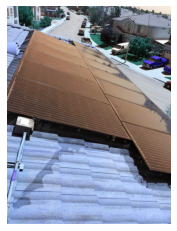

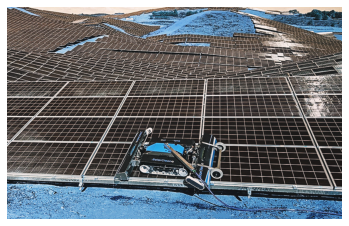

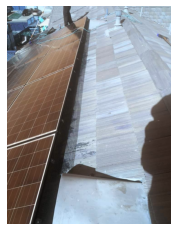

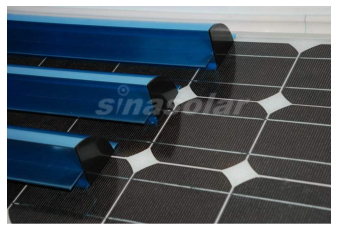

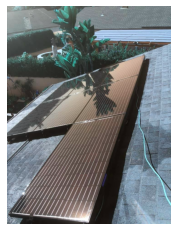

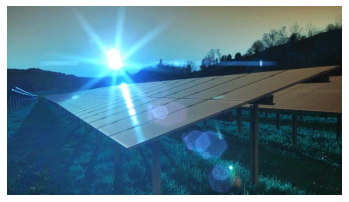

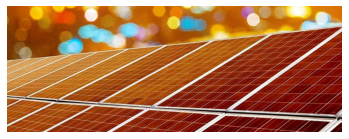

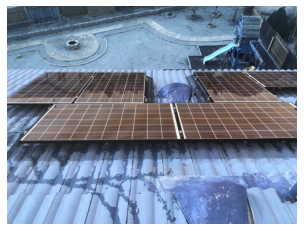

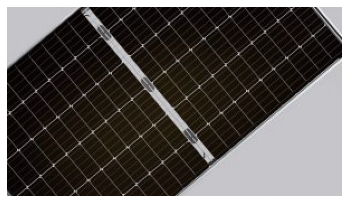

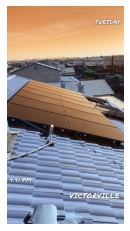

In [10]:
# Displaying clean solar panel images
image_paths = []
for filename in os.listdir(clean_images_dir):
    image_paths.append(filename)

i = 0
while (i != 10):
    image_path = random.choice(image_paths)
    image = os.path.join(clean_images_dir, image_path)
    img = cv2.imread(image)
    plt.imshow(img)
    plt.axis('off')
    plt.show()
    i = i + 1

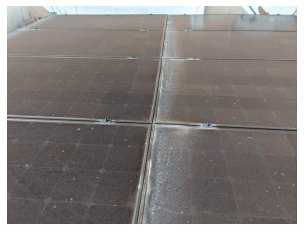

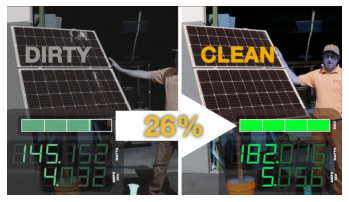

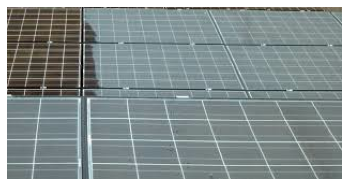

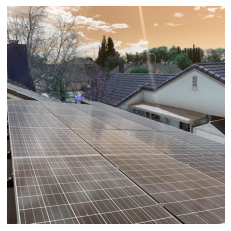

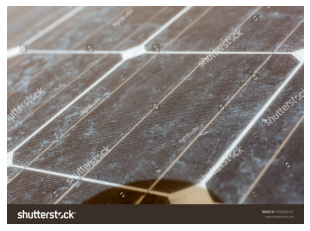

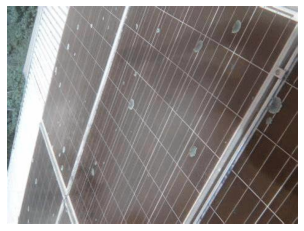

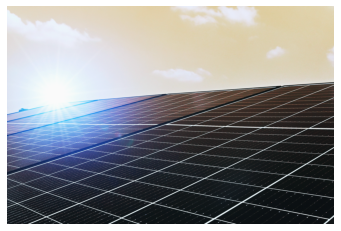

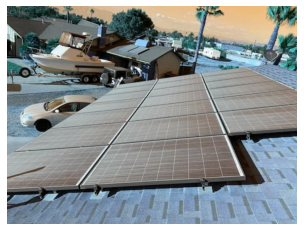

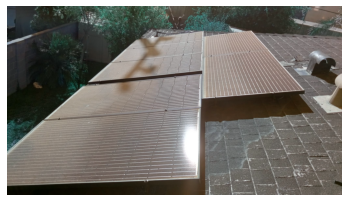

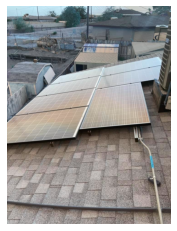

In [11]:
# Displaying clean solar panel images
image_paths = []
for filename in os.listdir(dusty_images_dir):
    image_paths.append(filename)

i = 0
while (i != 10):
    image_path = random.choice(image_paths)
    image = os.path.join(dusty_images_dir, image_path)
    img = cv2.imread(image)
    plt.imshow(img)
    plt.axis('off')
    plt.show()
    i = i + 1

In [12]:
dusty_labels = np.ones(len(dusty_images_array))
clean_labels = np.zeros(len(clean_images_array))

In [13]:
X = np.concatenate((clean_images_array, dusty_images_array))
y = np.concatenate((clean_labels, dusty_labels))

In [14]:
print("The shape of the input data: {}".format(X.shape))
print("The shape of the output data: {}".format(y.shape))

The shape of the input data: (2202, 224, 224, 3)
The shape of the output data: (2202,)


In [15]:
# Dividing the data into training, cross-validation and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2,
                                                   random_state = RANDOM_STATE,
                                                   stratify = y, shuffle = True)

X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size = 0.2,
                                                  random_state = RANDOM_STATE,
                                                  stratify = y_train, shuffle = True)

In [16]:
print("The shape of the input train data: {}".format(X_train.shape))
print("The shape of the input cross-validation data: {}".format(X_cv.shape))
print("The shape of the input test data: {}".format(X_test.shape))
print("----------------------------------------------------")
print("The shape of the output cross-validation data: {}".format(y_cv.shape))
print("The shape of the output train data: {}".format(y_train.shape))
print("The shape of the output test data: {}".format(y_test.shape))

The shape of the input train data: (1408, 224, 224, 3)
The shape of the input cross-validation data: (353, 224, 224, 3)
The shape of the input test data: (441, 224, 224, 3)
----------------------------------------------------
The shape of the output cross-validation data: (353,)
The shape of the output train data: (1408,)
The shape of the output test data: (441,)


In [17]:
# Performing normalization as part of feature engineering
X_train = X_train / 255
X_cv = X_cv / 255
X_test = X_test / 255

### MODEL

In [18]:
# Loading the MobileNet Model and using transfer learning for our task
headmodel = MobileNet(weights = "imagenet", include_top = False,
                 input_shape = (224, 224, 3))
model = headmodel.output
model = AveragePooling2D(pool_size = (2, 2))(model)
model = Flatten(name = 'flatten')(model)
model = Dense(64, activation = 'relu')(model)
model = Dropout(0.3)(model)
model = Dense(32, activation = 'relu')(model)
model = Dropout(0.1)(model)
model = Dense(1, activation = 'sigmoid')(model)

final_model = Model(inputs = headmodel.input, outputs = model)

for layer in headmodel.layers[: -2]:
    layer.trainable = False

opt = Adam(lr = 1e-2)
final_model.compile(loss = "binary_crossentropy", optimizer = opt,
                   metrics = ["accuracy"])

final_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                                      

In [19]:
fitted_model = final_model.fit(X_train, y_train, epochs = 20,
                              validation_data = (X_cv, y_cv),
                              batch_size = BATCH_SIZE)

Epoch 1/20
22/22 [==============================] - 56s 2s/step - loss: 0.7943 - accuracy: 0.5973 - val_loss: 0.5618 - val_accuracy: 0.7167
Epoch 2/20
22/22 [==============================] - 37s 2s/step - loss: 0.5479 - accuracy: 0.7209 - val_loss: 0.4873 - val_accuracy: 0.7762
Epoch 3/20
22/22 [==============================] - 36s 2s/step - loss: 0.4432 - accuracy: 0.7962 - val_loss: 0.4379 - val_accuracy: 0.8045
Epoch 4/20
22/22 [==============================] - 36s 2s/step - loss: 0.3576 - accuracy: 0.8480 - val_loss: 0.4071 - val_accuracy: 0.8357
Epoch 5/20
22/22 [==============================] - 39s 2s/step - loss: 0.2650 - accuracy: 0.8942 - val_loss: 0.4349 - val_accuracy: 0.8045
Epoch 6/20
22/22 [==============================] - 42s 2s/step - loss: 0.2091 - accuracy: 0.9112 - val_loss: 0.4180 - val_accuracy: 0.8215
Epoch 7/20
22/22 [==============================] - 37s 2s/step - loss: 0.2028 - accuracy: 0.9141 - val_loss: 0.4466 - val_accuracy: 0.8215
Epoch 8/20
22/22 [==

In [20]:
training_loss = fitted_model.history['loss']
cross_validation_loss = fitted_model.history['val_loss']
training_accuracy = fitted_model.history['accuracy']
cross_validation_accuracy = fitted_model.history['val_accuracy']
y_predictions_raw = final_model.predict(X_test)
y_predictions = zero_one_classifier(y_predictions_raw)

14/14 [==============================] - 6s 419ms/step


AUC for our classifier is: 0.8034586466165413


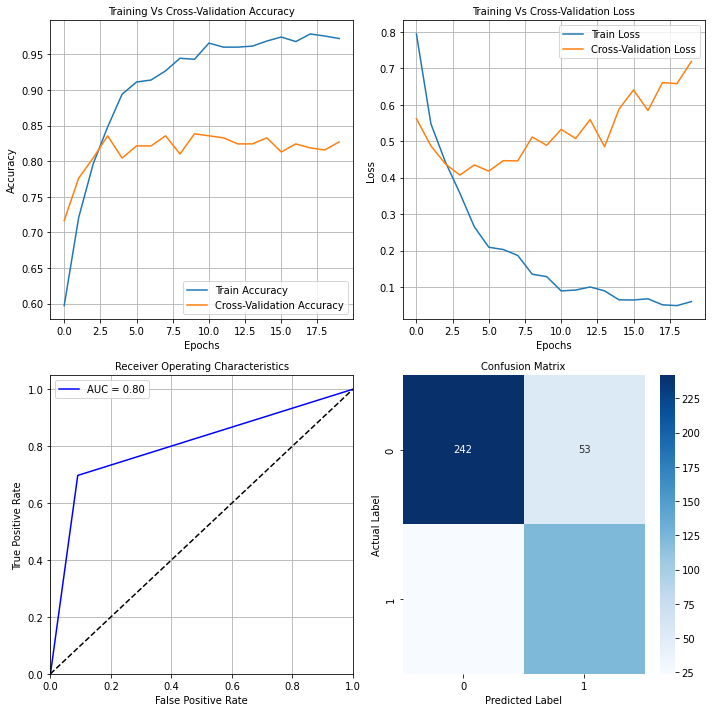

---------------------Classification Report---------------------
              precision    recall  f1-score   support

           0       0.91      0.82      0.86       295
           1       0.70      0.84      0.76       146

    accuracy                           0.83       441
   macro avg       0.80      0.83      0.81       441
weighted avg       0.84      0.83      0.83       441



In [21]:
metrics_tracker(training_accuracy, cross_validation_accuracy,
                   training_loss, cross_validation_loss, y_test, y_predictions)

In [24]:
model_path = "C:\design project/Teja.h5"

In [29]:
# After training the model

import os

# Create a directory to save the model if it doesn't exist
model_dir = "Models"
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

# Save the model
model_path = os.path.join(model_dir, "Teja.h5")
final_model.save(model_path)

print(f"Model saved to {model_path}")

Model saved to Models\Teja.h5
